# Project 2 - Feature Selection

## Part 1
3 classifiers: LDA, CNN and kNN. 

2 feature selection methods: backward selection, lasso embedding.

In [124]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


### Importing the dataset

Here we have a dataset of cats (label 0) and dogs (label 1), images of size 64x64

In [ ]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')


df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [126]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

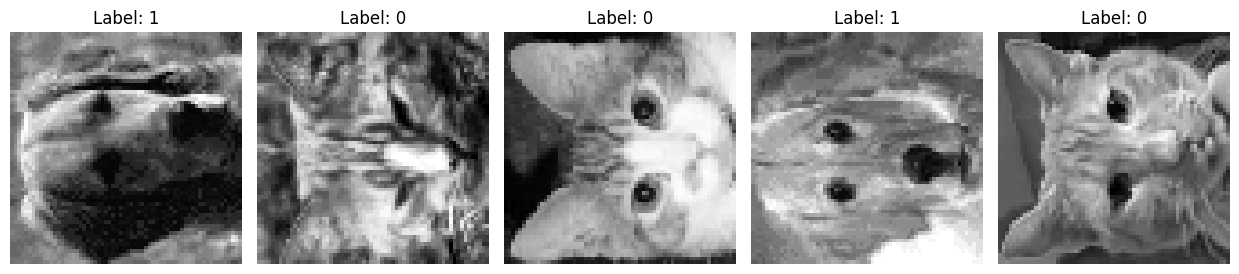

In [127]:
# plot example images
plot_examples(df, n=5)

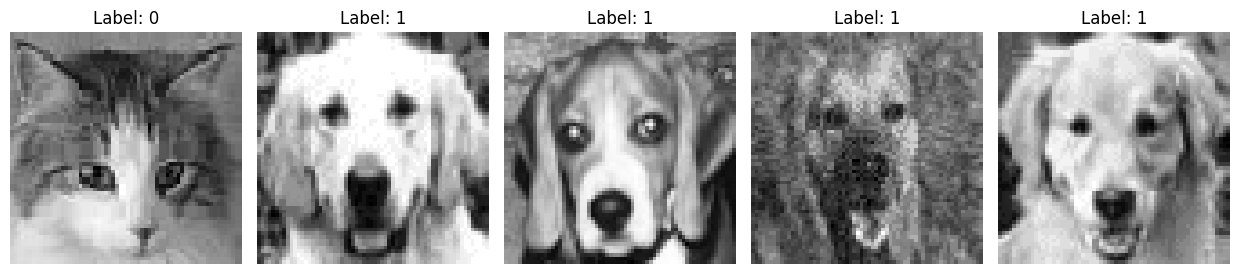

In [128]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

### Fixing the models

#### CNN

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# import pytorch lightning
import pytorch_lightning as pl

In [130]:
class PixelLassoCNN(pl.LightningModule):
    def __init__(self, l1_lambda=1e-2):
        super().__init__()
        self.input_mask = nn.Parameter(torch.ones(1, 1, 64, 64))  # same size as input

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)

        self.l1_lambda = l1_lambda

    def forward(self, x):
        x = x * self.input_mask  # Apply the learnable mask
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss

        self.log("train_loss", total_loss)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", total_loss)
        self.log("test_accuracy", total_accuracy)
        return total_loss, total_accuracy
    
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
# Load the data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Split the data into features and labels

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X = X.reshape(-1, 1, 64, 64)  # Reshape for CNN input

# Split the data into training and validation sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 126
Validation set size: 32
Test set size: 40


In [132]:
# Initialize the model
model = PixelLassoCNN()

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=150,
    accelerator="auto",
    logger=pl.loggers.TensorBoardLogger("logs/"),
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [133]:
# train the model
trainer.fit(model, train_loader, val_loader)

# Save the model
torch.save(model.state_dict(), "cat_dog_model.pth")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [134]:
# evaluate model
model.eval()

# retrieve the test accuracy
trainer.test(model, test_loader)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.699999988079071     │
│         test_loss         │     0.835391640663147     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.835391640663147, 'test_accuracy': 0.699999988079071}]

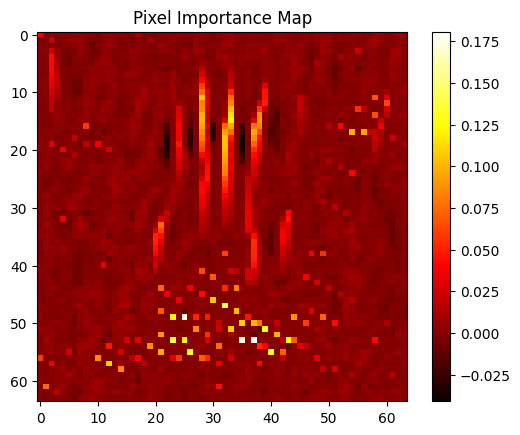

In [135]:
import matplotlib.pyplot as plt

mask = model.input_mask.detach().cpu().squeeze()
plt.imshow(mask, cmap='hot')
plt.title("Pixel Importance Map")
plt.colorbar()
plt.show()


### CV for finding optimal Lambda

In [136]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


In [137]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(model.device), y.to(model.device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [138]:
def run_cv_for_lambdas(dataset, lambdas, k_folds=5, batch_size=64, max_epochs=10):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for lmbda in lambdas:
        print(f"\nTesting lambda = {lmbda}")
        val_scores = []
        sparsities = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            print(f"  Fold {fold+1}/{k_folds}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size)

            model = PixelLassoCNN(l1_lambda=lmbda)

            trainer = pl.Trainer(
                max_epochs=max_epochs,
                enable_progress_bar=False,
                logger=False
            )
            trainer.fit(model, train_loader, val_loader)

            # Eval on validation set
            acc = evaluate_model(model, val_loader)
            mask = model.input_mask.detach().cpu().squeeze()
            sparsity = (mask.abs() < 0.01).float().mean().item()

            val_scores.append(acc)
            sparsities.append(sparsity)

        results.append({
            "lambda": lmbda,
            "val_acc_mean": np.mean(val_scores),
            "val_acc_std": np.std(val_scores),
            "sparsity_mean": np.mean(sparsities)
        })

    return results

def plot_cv_results(results):
    lambdas = [r["lambda"] for r in results]
    accs = [r["val_acc_mean"] for r in results]
    sparsities = [r["sparsity_mean"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(lambdas, accs, marker='o')
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(lambdas, sparsities, marker='o', color="red")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Sparsity (fraction of near-zero pixels)")

    plt.tight_layout()
    plt.show()



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.0
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/oskar/Coding/MVE441/project_2/checkpoints exists and is not empty.

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 1e-05
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.0001
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.001
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.01
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.05
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 5/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)



Testing lambda = 0.1
  Fold 1/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 2/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 3/5


`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


  Fold 4/5


`Trainer.fit` stopped: `max_epochs=25` reached.


  Fold 5/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | conv1        | Conv2d            | 320   
1 | conv2        | Conv2d            | 18.5 K
2 | pool         | AdaptiveAvgPool2d | 0     
3 | fc           | Linear            | 130   
  | other params | n/a               | 4.1 K 
---------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=25` reached.


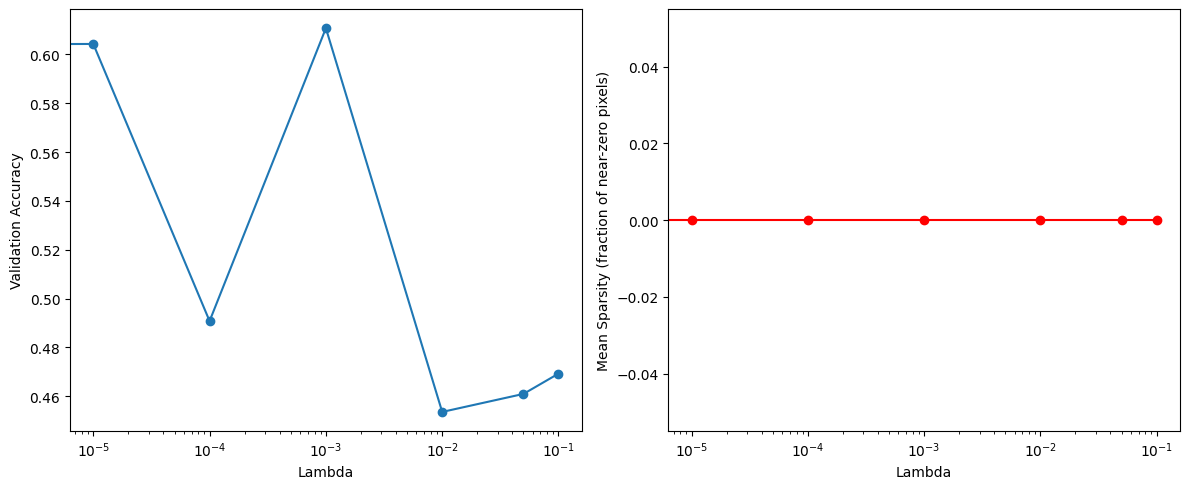

Best lambda: 0.001


In [ ]:
lambda_grid = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1]
results = run_cv_for_lambdas(train_dataset, lambdas=lambda_grid, max_epochs=25)

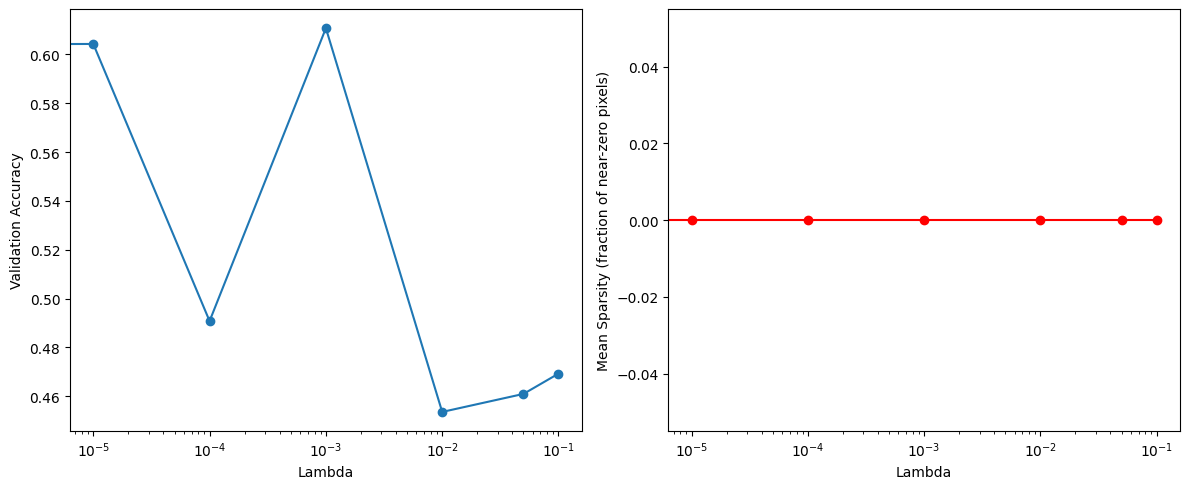

Best lambda: 0.001


In [140]:
plot_cv_results(results)

best = max(results, key=lambda r: r["val_acc_mean"] - 0.1 * r["sparsity_mean"])
print("Best lambda:", best["lambda"])

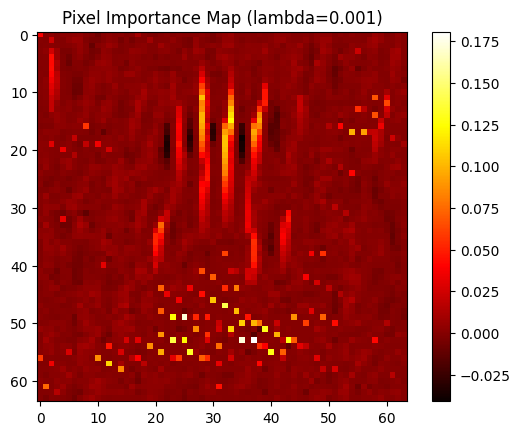

In [141]:
# plot mask for best lambda
model = PixelLassoCNN(l1_lambda=best["lambda"])
model.load_state_dict(torch.load("cat_dog_model.pth"))
model.eval()
mask = model.input_mask.detach().cpu().squeeze()
plt.imshow(mask, cmap='hot')
plt.title(f"Pixel Importance Map (lambda={best['lambda']})")
plt.colorbar()
plt.show()

### SVM using Lasso and Forward selection

In [49]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.svm import SVC
import numpy as np
import pandas as pd

In [36]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')
df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [71]:
# Pipeline for SVM using F-test
pipelineSVMFilter = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),  # Select top 30 features
    ('svm', SVC(kernel='linear'))
])

# Pipeline for SVM using embedded Lasso
pipelineSVMLasso = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000), 
        prefit=False
    )),
    ('svm', SVC(kernel='linear'))
])

pipelineSVMBoth = Pipeline([
    ('scaler', StandardScaler()),
    ('filtering', SelectKBest(score_func=f_classif, k=100)),  # First, F-test to top 50 features
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        prefit=False
    )),  # Then, Lasso
    ('svm', SVC(kernel='linear'))
])


In [44]:
# Cross-validate and return the fitted estimators
def fit_and_evaluate_pipeline(pipeline, Xdata, ydata, cv = 5):
    cv_results = cross_validate(
        pipeline, Xdata, ydata, 
        cv=5, 
        return_estimator=True
    )

    # Access all trained estimators
    fitted_pipelines = cv_results['estimator']

    # Now: Extract feature selection masks from each estimator
    masks = []
    for pipe in fitted_pipelines:
        mask = pipe.named_steps['feature_selection'].get_support()
        masks.append(mask)

    # Stack masks into array
    masks = np.array(masks)

    # How often each feature was selected across CV folds
    selection_counts = np.sum(masks, axis=0)

    print("Selection frequency for each feature:", selection_counts)

    print("CV Accuracy:", np.mean(cv_results['test_score']))

    return selection_counts, cv_results


Selection frequency for each feature: [0 0 0 ... 0 0 0]
CV Accuracy: 0.6757692307692307


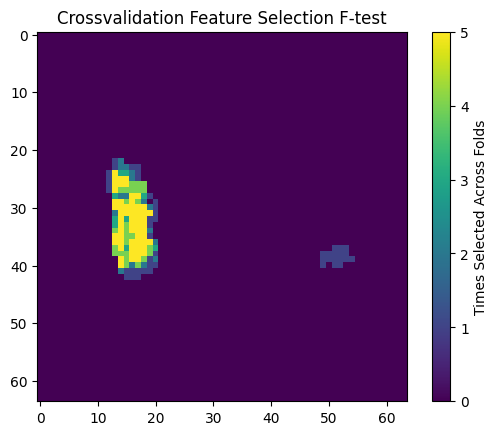

In [66]:
# Fit SVM and feature select using F-test

countsSVM, cvSMV = fit_and_evaluate_pipeline(pipelineSVMFilter, X, y)

size = (64,64)

heatmap = countsSVM.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection F-test')
plt.show()

Selection frequency for each feature: [0 0 0 ... 0 0 0]
CV Accuracy: 0.7723076923076924


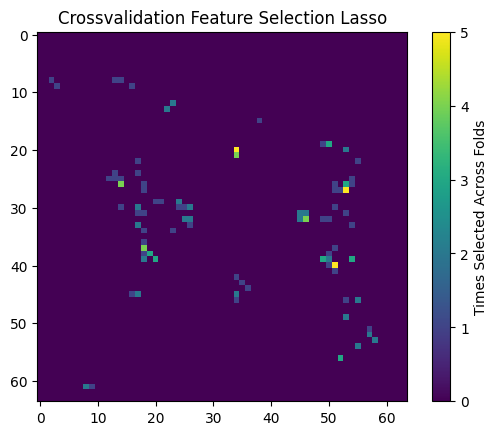

In [69]:
# Fit SVM and feature select using Lasso + LR

countsSVMLasso, cvSMVLasso = fit_and_evaluate_pipeline(pipelineSVMLasso, X, y)

size = (64,64)

heatmap = countsSVMLasso.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection Lasso')
plt.show()

Selection frequency for each feature: [0 1 0 0 0 1 0 1 0 2 2 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 2 1 2 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1]
CV Accuracy: 0.7015384615384616


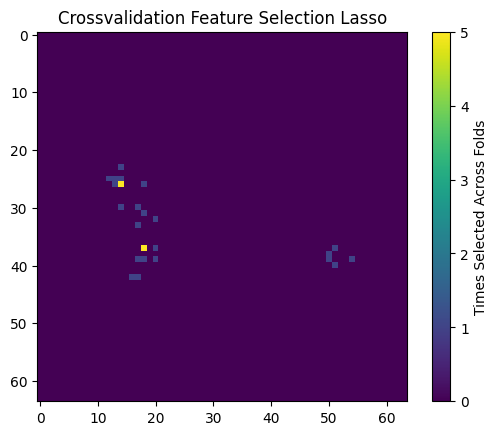

In [73]:
# Fit SVM and feature select using F-test and Lasso

countsSVMBoth, cvSVMBoth = fit_and_evaluate_pipeline(pipelineSVMBoth, X, y)

fit_pipe = cvSVMBoth['estimator']

size = (64,64)
full_masks = []
for pipe in fit_pipe:
    # Step 1: Which features survived the initial filter
    filtering_support = pipe.named_steps['filtering'].get_support()
    filtered_indices = np.where(filtering_support)[0]

    # Step 2: Which features survived Lasso among the filtered
    lasso_support = pipe.named_steps['feature_selection'].get_support()

    # Step 3: Map back to original feature space
    full_mask = np.zeros(X.shape[1], dtype=bool)
    full_mask[filtered_indices[lasso_support]] = True

    full_masks.append(full_mask)

# Stack masks
full_masks = np.array(full_masks)

# How often each pixel was selected
selection_counts = np.sum(full_masks, axis=0)

heatmap = selection_counts.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection Lasso')
plt.show()